In [116]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [117]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [118]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

In [119]:
train_dataset = ImageFolder('/kaggle/input/animefacedataset', transform = transform)

train_dataloader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True, num_workers = 3, pin_memory = True)

In [120]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [121]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [122]:
def show_images(images, nmax = 16):
    fig, ax = plt.subplots(figsize = (8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow = 8).permute(1,2,0))

def show_batch(dl, nmax = 16):
    for images, _ in dl:
        show_images(images, nmax)
        break

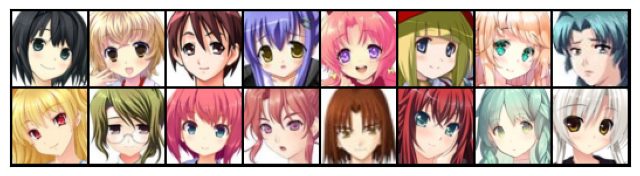

In [123]:
show_batch(train_dataloader)

In [124]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    
    return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        for b in self.dataloader:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dataloader)

In [125]:
device = get_default_device()
device

device(type='cuda')

In [126]:
train_dataloader = DeviceDataLoader(dataloader = train_dataloader, device = device)

In [127]:
# This is discriminator

discriminator = nn.Sequential(
    # in : batch x 3 x 64 x 64
    
    nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(num_features = 64),
    nn.LeakyReLU(0.2, inplace = True),
    # out : batch x 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(num_features = 128),
    nn.LeakyReLU(0.2, inplace = True),
    # out : batch x 128 x 16 x 16
    
    nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(num_features = 256),
    nn.LeakyReLU(0.2, inplace = True),
    # out : batch x 256 x 8 x 8
    
    nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(num_features = 512),
    nn.LeakyReLU(0.2, inplace = True),
    # out : batch x 512 x 4 x 4
    
    nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
    # out : batch x 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid()    
)

In [128]:
latent_size = 128

In [129]:
generator = nn.Sequential(
    # in : latent_size x 1 x 1
    
    nn.ConvTranspose2d(latent_size, 512, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(num_features = 512),
    nn.ReLU(inplace = True),
    # out : 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(num_features = 256),
    nn.ReLU(inplace = True),
    # out : 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(num_features = 128), 
    nn.ReLU(inplace = True),
    # out : 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(num_features = 64),
    nn.ReLU(inplace = True),
    # out : 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.Tanh()
    # out : 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


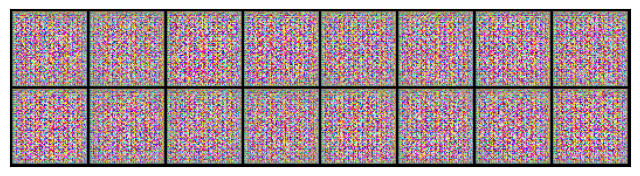

In [130]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [131]:
generator = to_device(generator, device)

discrminator = to_device(discriminator, device)

next(generator.parameters()).device

device(type='cuda', index=0)

In [132]:
def train_discriminator(real_images, optimizer_disc):
    # Clearing discriminator gradients
    
    optimizer_disc.zero_grad()
    
    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0),1, device = device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)
    
    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    # Update discirminator weights
    loss = real_loss + fake_loss
    loss.backward()
    optimizer_disc.step()
    return loss.item(), real_score, fake_score

In [133]:
def train_generator(optimizer_gen):
    # Clear the generator gradients
    optimizer_gen.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device = device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    optimizer_gen.step()
    
    return loss.item()

In [134]:
from torchvision.utils import save_image

In [135]:
import os
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [136]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('saving ', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize = (8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))

In [137]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device = device)

saving  generated-images-0000.png


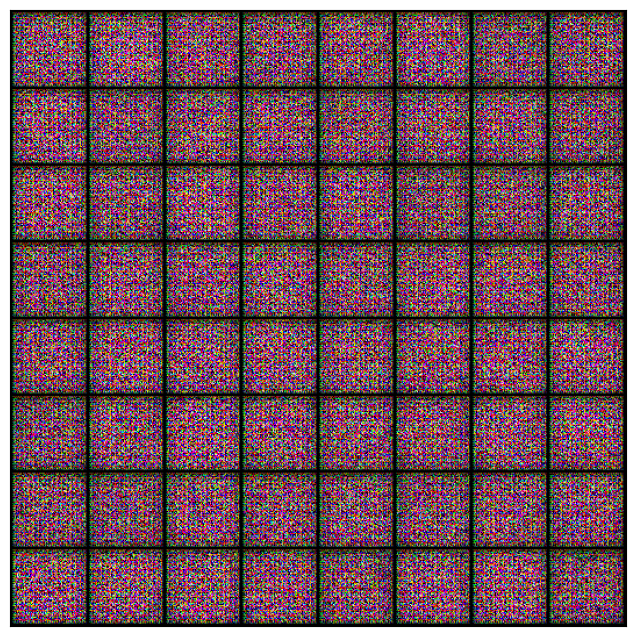

In [138]:
save_samples(0, fixed_latent)

In [139]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [140]:
def train(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dataloader):
            
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores 
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [141]:
lr = 0.0002
epochs = 10
train(epochs = epochs, lr = lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 6.4460, loss_d: 0.9162, real_score: 0.8846, fake_score: 0.4988
saving  generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 4.4408, loss_d: 0.3499, real_score: 0.7518, fake_score: 0.0338
saving  generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 7.8179, loss_d: 0.4410, real_score: 0.7067, fake_score: 0.0018
saving  generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 5.0105, loss_d: 0.3770, real_score: 0.8229, fake_score: 0.1325
saving  generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 8.6912, loss_d: 0.2823, real_score: 0.9782, fake_score: 0.2051
saving  generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 9.4636, loss_d: 0.5791, real_score: 0.6529, fake_score: 0.0001
saving  generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 7.3911, loss_d: 0.0767, real_score: 0.9965, fake_score: 0.0661
saving  generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 6.0058, loss_d: 0.1498, real_score: 0.9391, fake_score: 0.0590
saving  generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 5.7400, loss_d: 0.1649, real_score: 0.8886, fake_score: 0.0075
saving  generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 5.8108, loss_d: 0.1274, real_score: 0.9086, fake_score: 0.0092
saving  generated-images-0010.png


([6.445995330810547,
  4.440813064575195,
  7.817878723144531,
  5.01052188873291,
  8.691158294677734,
  9.463594436645508,
  7.391086101531982,
  6.005849838256836,
  5.740041732788086,
  5.810766220092773],
 [0.916181206703186,
  0.34987783432006836,
  0.44104310870170593,
  0.3769882917404175,
  0.28226038813591003,
  0.579095721244812,
  0.07667022943496704,
  0.14983344078063965,
  0.16491729021072388,
  0.1273784190416336],
 [0.8846453428268433,
  0.7517656087875366,
  0.7066952586174011,
  0.822941243648529,
  0.9781904220581055,
  0.6529184579849243,
  0.9964661002159119,
  0.9390952587127686,
  0.8885864615440369,
  0.9086073637008667],
 [0.4988254904747009,
  0.033772170543670654,
  0.0017949161119759083,
  0.13245165348052979,
  0.2050730139017105,
  9.976332512451336e-05,
  0.06612206995487213,
  0.058997657150030136,
  0.007511056959629059,
  0.009193744510412216])

In [142]:
!zip -r gan.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/generated/ (stored 0%)
  adding: kaggle/working/generated/generated-images-0007.png (deflated 0%)
  adding: kaggle/working/generated/generated-images-0002.png (deflated 0%)
  adding: kaggle/working/generated/generated-images-0005.png (deflated 0%)
  adding: kaggle/working/generated/generated-images-0008.png (deflated 0%)
  adding: kaggle/working/generated/generated-images-0003.png (deflated 0%)
  adding: kaggle/working/generated/generated-images-0000.png (deflated 0%)
  adding: kaggle/working/generated/generated-images-0006.png (deflated 0%)
  adding: kaggle/working/generated/generated-images-0009.png (deflated 0%)
  adding: kaggle/working/generated/generated-images-0010.png (deflated 0%)
  adding: kaggle/working/generated/generated-images-0004.png (deflated 0%)
  adding: kaggle/working/generated/generated-images-0001.png (deflated 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
